In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import en_core_web_sm
import joblib

In [3]:
# Open connection to MySQL

connection = mysql.connector.connect(host = 'localhost', port = 3306, user = 'Luthfiaed', passwd = '*', database = 'final_project')
database = connection.cursor(dictionary=True)

In [5]:
# Extract data from MySQL to dataframe
query = 'SELECT * FROM imdbMovies;'
database.execute(query)
data = database.fetchall()

dfImdb = pd.DataFrame(data)

In [7]:
# Select data based on criteria 
dfImdbEng = dfImdb[dfImdb.language.astype('str').str.contains("English")] 
dfImdb1990 = dfImdbEng[dfImdb.year >= 1990]
dfImdb_clean = dfImdb1990[dfImdb.description.notnull()]
dfImdb_clean.title = dfImdb_clean.title.apply(lambda x: x.lower())

dfImdb_clean.shape

<ipython-input-7-61f3993827c8>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfImdb1990 = dfImdbEng[dfImdb.year >= 1990]
<ipython-input-7-61f3993827c8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfImdb_clean = dfImdb1990[dfImdb.description.notnull()]
c:\users\luthf\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(28257, 22)

In [8]:
# Check data for null values
dfImdb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28257 entries, 4115 to 81266
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_title_id           28257 non-null  object 
 1   title                   28257 non-null  object 
 2   original_title          28257 non-null  object 
 3   year                    28257 non-null  int64  
 4   date_published          28257 non-null  object 
 5   genre                   28257 non-null  object 
 6   duration                28257 non-null  int64  
 7   country                 28239 non-null  object 
 8   language                28257 non-null  object 
 9   director                28228 non-null  object 
 10  writer                  28040 non-null  object 
 11  production_company      27060 non-null  object 
 12  actors                  28234 non-null  object 
 13  description             28257 non-null  object 
 14  avg_vote                28257 non-n

<blockquote><b>Note:</b><br> For the recommender website, the features from the dataframe that will be used are <b><i>title, year, genre, director, avg_vote, description</i></b>. Among these features, <b><i>director</i></b> has null values. One of the ways this can be solved is by using <b>GET API</b> from an external movie database, like what is done to show the movie poster in the Flask app. However, I don't do that here because director is not really a crucial information and can easily be googled if we know the title.</blockquote>

In [9]:
# Tokenization & Lemmatization of film description
nlp = en_core_web_sm.load()
stopwords = spacy.lang.en.stop_words.STOP_WORDS

listOfLemmas = []
for desc in dfImdb_clean.description :
    tokens = nlp(desc)
    lemmas = [token.lemma_ for token in tokens]
    lemmas_clean = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords]
    lemmas_string = " ".join(lemmas_clean)
    listOfLemmas.append(lemmas_string)

In [18]:
# Preview of Tokenization and Lemmatization
exampleString = dfImdb_clean.iloc[0].description
exampleTokenObject = nlp(exampleString)

exampleTokens = [token.text for token in exampleTokenObject]

exampleLemmas = [token.lemma_ for token in exampleTokenObject]
exampleLemmas_clean = [lemma for lemma in exampleLemmas if lemma.isalpha() and lemma not in stopwords]

print('original string:', exampleString)
print('tokenized string:', exampleTokens)
print('clean lemmatized tokens:', exampleLemmas_clean)

original string: An English Duke from 1876 is inadvertedly dragged to modern day New York where he falls for a plucky advertising executive.
tokenized string: ['An', 'English', 'Duke', 'from', '1876', 'is', 'inadvertedly', 'dragged', 'to', 'modern', 'day', 'New', 'York', 'where', 'he', 'falls', 'for', 'a', 'plucky', 'advertising', 'executive', '.']
clean lemmatized tokens: ['English', 'Duke', 'inadvertedly', 'drag', 'modern', 'day', 'New', 'York', 'fall', 'plucky', 'advertising', 'executive']


<center><b>TfIdf Formula</b><br><img src="./tfidf formula.png" style="height:250px;"></center>

In [33]:
# TfIdf

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2)
#                                    max_df=0.8, 
#                                    max_features=200000, 
#                                    min_df=0.2, 
#                                    use_idf=True
                                  )

tfIdfMatrix = tfidf_vectorizer.fit_transform([doc for doc in listOfLemmas])
tfIdfMatrix = tfIdfMatrix.astype(np.float32)

In [32]:
# Tfidf Vectorizer preview

tfidf_vectorizer_example = TfidfVectorizer()
tfidf_matrix_example = tfidf_vectorizer_example.fit_transform([doc for doc in listOfLemmas[0:2]])
print(listOfLemmas[0], listOfLemmas[1])
len(tfidf_matrix_example.toarray()[0])

English Duke inadvertedly drag modern day New York fall plucky advertising executive Hollywood director emerge semi exile plan complete work innovative motion picture


23

In [34]:
# Hitung skor kemiripan film
cos_similarity = cosine_similarity(tfIdfMatrix)

In [36]:
# Fungsi rekomendasi

def recommend(film) :                     
    filmIndex = dfImdb_clean.index.get_loc(dfImdb_clean[dfImdb_clean.title == film].index[0])
    similarMovies = list(enumerate(cos_similarity[filmIndex]))
    similarMovies = [i for i in similarMovies if i[0] != filmIndex]
    similarMovies = sorted(similarMovies, key=lambda x: x[1], reverse=True)

    similarMoviesIndexList = []
    for i in similarMovies:
        similarMoviesIndexList.append(i[0])
            
    dfSimilarMovies = dfImdb_clean.iloc[similarMoviesIndexList]
    return [i for i in dfSimilarMovies.iloc[0:5].title]

In [37]:
recommend('titanic')

['titanic - la leggenda continua',
 'cherry crush',
 'changing habits',
 'lady bird',
 'yelling to the sky']

In [146]:
# Save dataframe as joblib file for deployment
joblib.dump(dfImdb_clean, 'dfImdb_clean')

['dfImdb_clean']

In [38]:
# Save cos similarity score as joblib file for deployment
joblib.dump(cos_similarity, 'cosSim')

['cosSim']

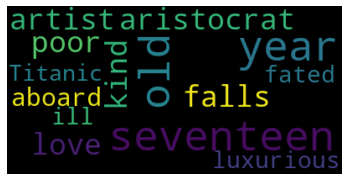

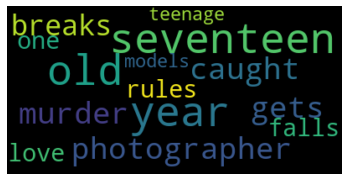

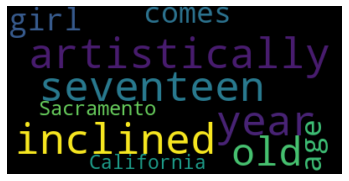

In [75]:
# Check summary wordclouds
from wordcloud import WordCloud, ImageColorGenerator

titanic = dfImdb_clean[dfImdb_clean.title == 'titanic'].description.iloc[0]
ladyBird = dfImdb_clean[dfImdb_clean.title == 'lady bird'].description.iloc[0]
cherryCrush = dfImdb_clean[dfImdb_clean.title == 'cherry crush'].description.iloc[0]

wcTitanic = WordCloud(max_font_size=50,background_color='black').generate(titanic)
wcLadyBird = WordCloud(max_font_size=50,background_color='black').generate(ladyBird)
wcCherryCrush = WordCloud(max_font_size=50,background_color='black').generate(cherryCrush)

plt.imshow(wcTitanic, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.imshow(wcCherryCrush, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.imshow(wcLadyBird, interpolation='bilinear')
plt.axis('off')
plt.show()